<br>

# OCR
---
<br>

<br>

## Overall structure of OCR <br><br>


### OCR = Text Detection + Text Recognition <br><br>


- __Text Detection__ 은 Segmentation 기반의 CRAFT 를 활용한 keras-ocr 라이브러리를 활용 <br><br>

    __CRAFT__ <br>
    개별 문자(character)에 대한 annotation 부족을 극복하기 위해 <br>
    character-level annotation 과 이미지 내에서 찾고자 하는 문자(character)의 annotation 을 모두 사용하여 <br>
    '문자들(characters) 사이의 affinity (관련성) 를 추정하는 방식을 사용. <br>
    \- 논문 abstract 일부 <br><br>

    참고. <br>
    [keras-ocr official github](https://github.com/faustomorales/keras-ocr) <br>
    [\[paper\] CRAFT (Character-Region Awareness For Text detection)](https://arxiv.org/pdf/1904.01941.pdf) <br>
    [CRAFT Pytorch implementation](https://github.com/clovaai/CRAFT-pytorch) <br>
    [CRAFT Keras github](https://github.com/notAI-tech/keras-craft) <br><br>


- __Text Recognition__ 은 라이브러리 사용하지 않고 직접 구현 <br><br>

    CTC 로 학습된 CRNN 이 사용됨 <br>
    CRNN : CNN + RNN + FCN 구조 네트워크 <br><br>

    __CRNN__ <br>
    CNN 과 RNN 의 아이디어를 결합한 Text Recognition 의 초기 모델 (2015 년 등장). <br><br>

    CRNN 이후 <br>
    다양한 모델들이 Text Recognition task 의 새로운 기법을 제시하며 성능 향상 <br><br>

    참고. <br>
    [\[paper\] What is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis](https://arxiv.org/pdf/1904.01906.pdf) <br>
    위 논문에 의하면, CRNN 보다 높은 성능을 낸 모델이 갖는 두 가지 다른 점은, <br>
    입력이미지 변환 단계에서는 모델의 앞에서 글자를 Thin plate spline Transformation을 해주는 TPS 모듈이 붙는 점과 <br>
    마지막 Text 출력 단계에서는 Bidirectional LSTM 뒤로 Attention decoder가 붙는 점.
    

<br>

<br>

## Dataset for OCR <br><br>

OCR 데이터셋에 필요한 많은 텍스트 정보를 사람이 만들어 내는 수고로움을 해결하기 위해, <br>
컴퓨터로 원하는 언어, 폰트, 배치, 크기로 문자 이미지를 대량으로 만들어 사용합니다. <br><br>


### MJ Synth 데이터셋 <br><br>

이런식으로 만들어진 대량의 Text Dataset 은 Text Recognition model 의 정량적 평가를 위해 많이 사용됩니다. <br>
주로 아래의 두 가지가 많이 사용됩니다. <br><br>

1. [MJ Synth](http://www.robots.ox.ac.uk/~vgg/data/text/) <br>
2. [SynthText](http://www.robots.ox.ac.uk/~vgg/data/scenetext/) <br><br>

    링크. <br>
    Naver Clova 의 논문 저자 제공 MJ Synth 데이터셋 다운로드 링크 : [Dropbox-data_lmdb_release](https://www.dropbox.com/sh/i39abvnefllx2si/AAAbAYRvxzRp3cIE5HzqUw3ra?dl=0) <br><br>

    커널. <br>
    위 링크의 다운로드를 커널을 통해 실행합니다.
    ```
    $ mkdir -p ~/aiffel/ocr
    $ cd ~/aiffel/ocr
    $ wget https://www.dropbox.com/sh/i39abvnefllx2si/AABX4yjNn2iLeKZh1OAwJUffa/data_lmdb_release.zip
    $ unzip data_lmdb_release.zip
    $ mv data_lmdb_release/training/MJ .  # data_lmdb_release/training/MJ 아래의 데이터만 ~/aiffel/ocr 아래로 가져옵니다.
    # 이후 불필요한 data_lmdb_release.zip 및 data_lmdb_release 하위의 남은 데이터는 삭제하셔도 무방합니다.
    ```
    <br>
    

### LMDB (Lightning Memory-Mapped Database) <br><br>

데이터셋은 lmdb 포맷(.mdb) 파일로 이루어져 있습니다. <br>
LMFB 는 Symas 에서 만든 Lightning Memory-Mapped Database 입니다. <br><br>

- lmdb 데이터셋을 다루기 위해 파이썬을 위한 lmdb 모듈을 받아야 합니다. <br><br>

    ```
    $ pip install lmdb
    # or
    $ conda install -c conda-forge python-lmdb
    ```

<br>

In [1]:
# 기본 경로 설정 

import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/home/ssac29/aiffel/ocr


In [2]:
# 필요한 라이브러리 임포트

import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

In [3]:
# lmdb 라이브러리로 MJ dataset 불러오기

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

# 클라우드 사용자는 아래 주석을 사용해 주세요.
# TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
# VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
# TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'
print(TRAIN_DATA_PATH)

/home/ssac29/aiffel/ocr/MJ/MJ_train


<br>

## Text Recognition 모델 구현 <br><br>

논문에서 소개된 CRNN 구조를 활용하여 Text Recognition 모델 구현 <br>

- __CRNN__ <br>
    CNN + RNN + FCN 구조 네트워크 <br><br>

    참고. <br>
    [\[paper\] An End-to-End Trainable Neural Network for Image-based SequenceRecognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)

<br>

<br>

### CRNN 네트워크의 구조 <br><br>

Convolution layer 를 통해 feature 추출 <br>
Recurrent layer 를 통해 추출된 feature 의 전체적인 context 를 파악. 다양한 output 크기에 대응 <br>
Transcription layer 를 통해 step 마다 어떤 character 의 확률이 높은지 예측. <br>
( Transcription layer 는 Fully Connected Layer ) <br><br>


Type | Configuragions
:---: | :---:
Transcription | -
Bidirectional-LSTM | # hidden units : 256
Bidirectional-LSTM | # hidden units : 256
Map-to-Sequence | -
Convolution | # maps : 512, k : 2x2, s : 1, p : 0
MaxPooling | Window : 1x2, s : 2
BatchNormalization | -
Convolution | # maps : 512, k : 3x3, s : 1, p : 1
BatchNormalization | -
Convolution | # maps : 512, k : 3x3, s : 1, p : 1
MaxPooling | Window : 1x2, s : 2
Convolution | # maps : 256, k : 3x3, s : 1, p : 1
Convolution | # maps : 256, k : 3x3, s : 1, p : 1
MaxPooling | Window : 2x2, s : 2
Convolution | # maps : 128, k : 3x3, s : 1, p : 1
MaxPooling | Window : 2x2, s : 2
Convolution | # maps : 64, k : 3x3, s : 1, p : 1
Input | W x 32 gray-scale image

<br>

In [4]:
# Text Recognition 할 타겟 지정
# 여기서는 0~9 까지의 숫자 character 10가지와 A~Z 까이의 알파벳 대문자 character 26 가지로 지정

NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


<br>

### Input Image : 모델 학습용 input dataset 생성 <br><br>


Text Recognition 모델을 학습하기 위해 <br>
모델의 입력값으로 주어지는 input text image dataset 을 생성 <br><br>


#### MJDatasetSequence 클래스 작성 <br><br>


lmdb 를 활용하여 케라스 모델을 학습하기 위한 MJ Synth 데이터셋을 불러오는 파이썬 클래스 구현 <br><br>


- 구현할 인자 <br>

    - ```dataet_path``` : 읽어올 데이터셋 경로 <br>
    - ```label_converter``` : 문자를 미리 정의된 index 로 변환해주는 converter <br>
    - ```batch_size``` : 학습용 데이터 배치 사이즈 <br>
    - ... <br>
    - 그 외에 필터링을 위한 최대 글자 수, 학습 대상이 될 character 한정 등 ... <br><br>

- 구현할 메소드 <br>

    - ```_get_img_label()``` : 이미지 데이터를 ```img, label``` 쌍으로 가져오는 메소드 <br>
        ( 이 메소드 안에서 다양한 사이즈의 이미지를 모두 H:32 x W:최대100 으로 맞추도록 가공 ) <br>
    - ```__getitem__()``` : 케라스의 ```model.fit()``` 에서 호출되어 배치 단위만큼 데이터셋을 가져와 리턴 <br>
    - ...
    
<br>

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


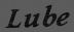

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


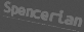

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


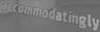

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


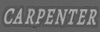

In [5]:
# 원본 데이터셋 안에 있는 이미지 확인 (shape, label 등 ...)
# lmdb 를 통해 training dataset 이미지 4 개만 확인

from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

<br>

대부분의 이미지의 height는 31, 최대 32 <br> 
width는 문자열 길이에 따라 다양

<br>

In [6]:
# Text Recognition model 학습을 위한 Input dataset 을 생성하는 파이썬 클래스 생성
# MJ Synth 데이터셋을 lmdb 라이브러리로 불러와 구현
# 케라스 모델 학습에 필요한 여러 인자와 메소드를 구현

class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

<br>

### Encode : Text Class -> Class Index 변환 <br><br>


Text Recognition 모델 학습을 위해 <br>
모델의 출력값으로 주어지는 Text Class 를 Class Index 로 변환 <br><br>


#### LabelConverter 클래스 작성 <br><br>

MJ Synth 데이터셋에서 받은 text 로 된 class 를 index 형태의 class 로 encoding 해주는 클래스를 작성 <br><br>


- ```__init__()``` : 입력받은 text 의 각 character 들이 ```self.dict``` 의 어떤 index 에 매핑 되는지 저장 <br>
( ex. 만약 ```character='ABCD'``` 라면, ```'A'``` 의 label 은 ```1```, ```'B'``` 의 label 은 ```2``` 가 되도록 저장 ) <br>
- ```encode()``` : 입력받은 text 의 character 를 index 로 매핑하여 저장. 공백(blank) 문자를 지정. (```'-'``` 문자를 활용, label 은 ```0```) <br>
- ```decode()``` : 각 index 를 다시 character 로 변환 (이후 text 로 바꿔 줌)

<br>

In [7]:
# 데이터셋의 class 를 text -> index 로 매핑해주는 인코더 클래스 작성

class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [8]:
# 위에서 정의한 TARGET_CHARACTERS 확인

print(TARGET_CHARACTERS)

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


In [9]:
# 'HELLO' 텍스트를 encode 후 decode 하여 클래스 작동 확인
# 동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있습니다.

label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


<br>

### CRNN 모델 구성 <br><br>

위에서 모델의 입력과 출력을 준비하였습니다. <br>
여기에 케라스에서 제공하는 CTC Loss function 을 활용하여 CRNN 모델을 구현합니다. <br>
( CTC Loss function 에 대한 설명은 아래 참고 ) <br><br>


CRNN 모델은 논문에 나와있는 네트워크 구조를 참고하여 작성 <br><br>

Type | Configuragions
:---: | :---:
Transcription | -
Bidirectional-LSTM | # hidden units : 256
Bidirectional-LSTM | # hidden units : 256
Map-to-Sequence | -
Convolution | # maps : 512, k : 2x2, s : 1, p : 0
MaxPooling | Window : 1x2, s : 2
BatchNormalization | -
Convolution | # maps : 512, k : 3x3, s : 1, p : 1
BatchNormalization | -
Convolution | # maps : 512, k : 3x3, s : 1, p : 1
MaxPooling | Window : 1x2, s : 2
Convolution | # maps : 256, k : 3x3, s : 1, p : 1
Convolution | # maps : 256, k : 3x3, s : 1, p : 1
MaxPooling | Window : 2x2, s : 2
Convolution | # maps : 128, k : 3x3, s : 1, p : 1
MaxPooling | Window : 2x2, s : 2
Convolution | # maps : 64, k : 3x3, s : 1, p : 1
Input | W x 32 gray-scale image

<br>

<br>

#### CTC Loss function <br><br>


노드 12-7 참고하여 정리 <br><br>


```K.ctc_batch_cost(y_true, y_pred, input_length, label_length)``` 의 4가지 인자 <br>

- ```y_true```: tensor (samples, max_string_length) containing the truth labels.
- ```y_pred```: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
- ```input_length tensor```: (samples, 1) containing the sequence length for each batch item in y_pred.
- ```label_length tensor```: (samples, 1) containing the sequence length for each batch item in y_true.
    ( samples 는 배치사이즈를 의미) <br><br>


참고. <br>
[Tensorflow Tutorial - ctc_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)

<br>

In [10]:
# 케라스에서 제공하는 K.ctc_batch_cost() 를 이용하여 CTC loss 를 계산하는 함수 작성

def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [11]:
# CRNN 모델을 생성하는 함수 작성
# 위에서 작성한 ctc_lambda_func() 으로 CTC loss 를 적용

def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

<br>

## 모델 학습 <br><br>

MJDatasetSequence 로 데이터셋을 분리하여 학습 진행 <br>
1 Epoch 당 10 초 정도 소요

<br>

In [12]:
# gpu 사용 가능여부 확인

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11474825320938335237,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5802096064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6175725625237708828
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [13]:
# 모델 학습 및 평가용 데이터셋 준비
# MJDatasetSequence 로 데이터셋 분리

train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

In [14]:
# 모델 생성

model, y_func = build_crnn_model()

In [15]:
# 모델 shape 확인

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [16]:
# 모델 checkpoint 경로설정 및 callback 객체 생성 
# 학습용 sgd 설정 후 모델 컴파일

checkpoint_path = HOME_DIR + '/model_checkpoint_02.hdf5'
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)

In [17]:
tf.__version__

'2.4.1'

In [18]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14726736399147377092,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5802096064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9037722200063513851
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [19]:
# 모델 학습

model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - 31s 183ms/step - loss: 33.9601 - val_loss: 27.2747

Epoch 00001: val_loss improved from inf to 27.27466, saving model to /home/ssac29/aiffel/ocr/model_checkpoint_02.hdf5
Epoch 2/100
63/63 [==============================] - 10s 156ms/step - loss: 26.5648 - val_loss: 26.6460

Epoch 00002: val_loss improved from 27.27466 to 26.64597, saving model to /home/ssac29/aiffel/ocr/model_checkpoint_02.hdf5
Epoch 3/100
63/63 [==============================] - 10s 156ms/step - loss: 26.0719 - val_loss: 28.2489

Epoch 00003: val_loss did not improve from 26.64597
Epoch 4/100
63/63 [==============================] - 10s 155ms/step - loss: 25.6588 - val_loss: 25.7129

Epoch 00004: val_loss improved from 26.64597 to 25.71294, saving model to /home/ssac29/aiffel/ocr/model_checkpoint_02.hdf5
Epoch 5/100
63/63 [==============================] - 9s 148ms/step - loss: 25.2083 - val_loss: 26.4960

Epoch 00005: val_loss did not improve from 25.71294
Epoch 6/

<br>

## 모델 학습 결과 확인 <br><br>

테스트 데이터셋으로 학습된 모델을 통해 inference 진행 후 눈으로 확인

<br>

Result: 	 SLINKING9999999999999999


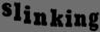

Result: 	 ALEPPO99999999999999999


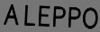

Result: 	 RWENDA999999999999999999


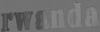

Result: 	 NATHANS99999999999999999


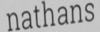

Result: 	 KALLAO99999999999999999


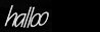

Result: 	 HURLS9999999999999999999


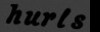

Result: 	 DOWNSIZE9999999999999999


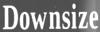

Result: 	 FOBOTIC99999999999999999


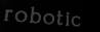

Result: 	 SLOPPY99999999999999999


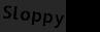

Result: 	 HERMITE99999999999999999


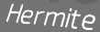

In [85]:
# 학습된 모델 inference 및 확인

from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        # inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

In [110]:
print(test_set[0][0]['input_image'][0:1,:,:,:].shape)

(1, 100, 32, 3)


<br>

# 프로젝트 End-to-End OCR <br><br>



<br>

<br>

## Text Detection 구현 

<br>

In [169]:
# 필요한 모듈 임포트

import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [170]:
# keras_ocr.detection

from keras_ocr.detection import Detector

detector = Detector()

Looking for /home/ssac29/.keras-ocr/craft_mlt_25k.h5


In [171]:
# sample image path

SAMPLE_IMG_PATH = HOME_DIR + '/sample.jpg'

In [172]:
# Text Detection 함수 작성
# 이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 작성

def detect_text(img_path):

    # importing image data with opencv
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]

    # text detection with keras_ocr's Detector()
    result = detector.detect(input_img)
    ocr_result = result[0]

    cropped_imgs = []
    for text_result in ocr_result:

        # draw line with cv2.line() method
        for i in range(4):
            if i==3:
                a = (round(text_result[3][0]), round(text_result[3][1]))
                b = (round(text_result[0][0]), round(text_result[0][1]))
                line_img = cv2.line(line_img,a,b,(0,0,255),10)
            else:
                a = (round(text_result[i][0]), round(text_result[i][1]))
                b = (round(text_result[i+1][0]), round(text_result[i+1][1]))
                line_img = cv2.line(line_img,a,b,(0,0,255),10)

        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
        
    return line_img, cropped_imgs

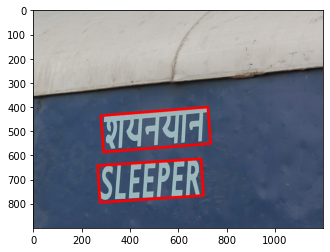

In [173]:
# inference 후 시각화

img, cropped_img = detect_text(SAMPLE_IMG_PATH)
plt.imshow(img[:,:,::-1])

<br>

## Text Recognition 구현

<br>

In [174]:
# Inference function with trained model

def check_inference_02(model, cropped_img):
    output = model_pred.predict(cropped_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(cropped_img[0].transpose(1,0,2).astype(np.uint8)))

In [175]:
# Text Recognition 함수 작성

def recognize_img(pil_img, input_img_size=(100,32)):

    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!

    # data : PIL image
    img = Image.fromarray(pil_img)
    img = img.resize(input_img_size)    # resize image for the input of the trained model

    # data transformation : PIL -> numpy_array
    img_arr = np.array(img).transpose(1,0,2)
    img_arr = np.expand_dims(img_arr, axis=0)

    check_inference_02(model, img_arr)
    

Result: 	 REAIN9999999999999999999


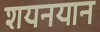

Result: 	 SLEEPER9999999999999999


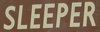

In [176]:
# 확인

for _img in cropped_img:
    recognize_img(_img)